In [2]:
import json

from pandas.io.json import json_normalize
import plotly.express as px
import ipywidgets as widgets
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats


# reading the JSON data using json.load()
file ='clean_data_sub-Copy1.json'
with open(file) as train_file:
    dict_train = json.load(train_file)


In [3]:
total=[]
for patient in dict_train:
    test1=[]
    for num in range (0,len(dict_train[patient])):
        test1.append(dict_train[patient][num]['ICD_9'])
    total.append(test1)

In [4]:
import gensim
from gensim.models import Word2Vec
model_ted = Word2Vec(sentences=total, size=100, window=20, min_count=1, workers=4, sg=1,iter=100)
#model_ted.wv.most_similar("80124")

In [5]:
my_dict = dict({})
for idx, key in enumerate(model_ted.wv.vocab):
    my_dict[key] = model_ted.wv[key]

In [6]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import numpy as np

# Section

In [8]:
### Patient Retrieval

In [9]:
####  Similar Patient Retrieval

In [10]:
mu_label = widgets.Label(value="similarPatients")
mu_var = widgets.Text(description="Patient", value="4579")
button = widgets.Button(description="Calculate")
widgets.VBox([mu_label, mu_var,button])

In [11]:
out = widgets.Output()

In [12]:


def most_similar_patient(change):
    patient= mu_var.value
    with out:
        clear_output()
        d=dict()
        patient_num=[]
        similarity=dict()
        target_patient=dict_train[patient]
        l=[]
        for event in range(0,len(target_patient)):
            icd=target_patient[event]['ICD_9']
            embedding=my_dict[icd]
            l.append(embedding)
        d[patient]=l
        for patients in dict_train:
            m=[]
            patient_event=dict_train[patients]
            for event in range(0,len(patient_event)):
                icd=patient_event[event]['ICD_9']
                embedding=my_dict[icd]
                m.append(embedding)
            d[patients]=m
        for key in d.keys():
            patient_num.append(key)
            distance, path = fastdtw(l,d[key],dist=euclidean)
            similarity[key]=distance
        top5=sorted(similarity.items(), key=lambda x: x[1])[:5]
        print('Patient historical record\n',json_normalize(dict_train[patient]))
        print('Top5 similar patient',top5)

mu_var.observe(most_similar_patient, names="value")
button.on_click(most_similar_patient)

In [13]:
most_similar_patient(None)
out

Output()

In [30]:
labels = widgets.Label(value="Compare similiarity of two patients")
Patient_A = widgets.Text(description="Patient A", value="4579")
Patient_B = widgets.Text(description="Patient B", value="2080")
button1 = widgets.Button(description="Calculate")
widgets.VBox([labels,Patient_A,Patient_B,button1])


In [15]:
out1=widgets.Output()

In [1]:
def patient_similartiy(Patient_A,Patient_B):
    pa_icd=[]
    pb_icd=[]
    for event in range(0,len(dict_train[Patient_A])):
        icd=dict_train[Patient_A][event]['ICD_9']
        embedding=my_dict[icd]
        pa_icd.append(embedding)
    for event in range(0,len(dict_train[Patient_B])):
        icd=dict_train[Patient_B][event]['ICD_9']
        embedding=my_dict[icd]
        pb_icd.append(embedding)
    distance, path = fastdtw(pa_icd,pb_icd,dist=euclidean)
    index_a,index_b=zip(*path)
    plot=plt.plot(index_a,index_b, color='k', linewidth=2)
    #fig = go.Figure(data=go.Scatter(x=index_a, y=index_b))
    figures = px.line(x=index_a, y=index_b, labels={'x':'Patient_a', 'y':'Patient_b'})
    return(distance,path,plot.show())


In [17]:
#def on_value_change(change):
    #Patient_A = Patient_A.value
    #Patient_B= Patient_B.value
#    out.clear_output()
#    with out:
#        display(patient_similartiy(Patient_A.value,Patient_B.value))

#def btn_eventhandler(obj):
#    return(patient_similartiy,{'Patient_A': Patient_A.value, 'Patient_B': Patient_B.value})

def on_button_clicked(change):
      # "linking function with output"
    
    with out1:
        clear_output()
        # what happens when we press the button
        print(patient_similartiy(Patient_A.value,Patient_B.value))
Patient_A.observe(on_button_clicked, names="value")
Patient_B.observe(on_button_clicked, names="value")

button1.on_click(on_button_clicked)

In [91]:
on_button_clicked(None)
out1

Output(outputs=({'output_type': 'display_data', 'data': {'text/html': '        <script type="text/javascript">…

# ICD-9 Retrival

In [ ]:
#ICD-9 Retrival

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [84]:
icd9_label = widgets.Label(value="Input ICD9")
icd9_var= widgets.Text(description="ICD9")
widgets.VBox([icd9_label,icd9_var])
button2= widgets.Button(description="Calculate")
widgets.VBox([icd9_label,icd9_var,button2])

In [88]:
out2 = widgets.Output()

In [89]:
def display_closestwords_tsnescatterplot(model, word):

    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    vector_dim = model.vector_size
    # add the vector for each of the closest words to the array
    arr = np.empty((0,vector_dim), dtype='f')
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.savefig('demonew_test++.png', bbox_inches='tight')

In [102]:
def on_button_clicked2(change):
      # "linking function with output"
    model=model_ted
    word=icd9_var.value
    with out2:
        clear_output()
        # what happens when we press the button
        return(display_closestwords_tsnescatterplot(model,word))
icd9_var.observe(on_button_clicked2, names="value")

button2.on_click(on_button_clicked2)

Output(outputs=({'output_type': 'stream', 'text': 'C:\\Users\\ariaa\\Anaconda3\\lib\\site-packages\\ipykernel_…

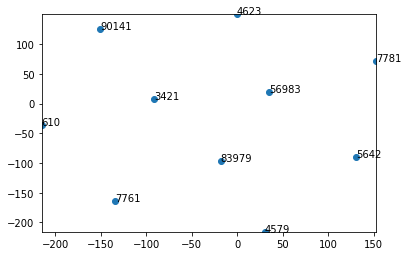

In [101]:
on_button_clicked2(None)
out2